## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 
    
Автор материала: Юрий Кашницкий (@yorko в Slack ODS). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание № 8 (демо)
## <center> Реализация алгоритмов онлайн-обучения

Вам предлагается реализовать два алгоритма – регрессор и классификатор, обучаемые стохастическим градиентным спуском (Stochastic Gradient Descent, SGD). [Веб-форма](https://docs.google.com/forms/d/1xlbc0CaUaNpVs-fhxkHUe61AtsvS_aDqQ0CLFxs6UDA) для ответов.

## План домашнего задания
    1. Линейная регрессия и SGD
    2. Логистическая регрессия и SGD
    3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

В [статье](https://habrahabr.ru/company/ods/blog/326418/) было описано, как таким образом обучать регрессор, т.е. минимизировать квадратичную функцию потерь. Реализуем этот алгоритм.

##  1. Линейная регрессия и SGD

In [ ]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.metrics import log_loss, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

Реализуйте класс `SGDRegressor`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$) и `n_iter` – число проходов по выборке (по умолчанию 10)
- также в конструкторе должны создаваться списки `mse_` и `weights_` для отслеживания значений среднеквадратичной ошибки и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit` и `predict`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса (см. [статью](https://habrahabr.ru/company/ods/blog/326418/)), а также записывает получившиеся на данной итерации значения среднеквадратичной ошибки (именно MSE, SE слишком большими будут) и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDRegressor`, т.е. `self`
- Метод `predict` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает вектор прогнозов модели, используя созданный методом `fit` вектор весов `w_`.

In [ ]:
# Simple example. Test SGD
w = np.array([2., 3.])
y = np.array([4.5, 7.7, 8.9])
x = np.array([[1., 5.], [1., 11.], [1., 13.]])
print('y:', y)
print()
print('iter: 0')
print('pred:', np.round(np.dot(x, w), 1))
print('w:', w)
print('mse:', np.round(1/3*(y - np.dot(x, w))**2, 1), ', rmse:', np.round(np.sum(1/3*(y - np.dot(x, w))**2)**0.5,2))
print()

eta = 1e-2
for k in range(5):
  for i in range(3):
    w[0] += eta * (y[i]-w[0]-w[1]*x[i, 1])
    w[1] += eta * (y[i]-w[0]-w[1]*x[i, 1])*x[i, 1]
  print('iter:', k+1)
  print('pred:', np.round(np.dot(x, w), 1))
  print('w:', np.round(w,3))
  print('mse:', np.round(0.5*(y - np.dot(x, w))**2, 2), ', rmse:', np.round(np.sum(1/3*(y - np.dot(x, w))**2)**0.5,2))
  print()

y: [4.5 7.7 8.9]

iter: 0
pred: [17. 35. 41.]
w: [2. 3.]
mse: [ 52.1 248.4 343.5] , rmse: 25.38

iter: 1
pred: [ 5.8 10.7 12.4]
w: [1.722 0.821]
mse: [0.88 4.65 6.09] , rmse: 2.78

iter: 2
pred: [4.6 8.2 9.4]
w: [1.693 0.59 ]
mse: [0.01 0.12 0.11] , rmse: 0.39

iter: 3
pred: [4.5 7.9 9. ]
w: [1.689 0.565]
mse: [0.   0.02 0.01] , rmse: 0.15

iter: 4
pred: [4.5 7.9 9. ]
w: [1.689 0.563]
mse: [0.   0.02 0.01] , rmse: 0.12

iter: 5
pred: [4.5 7.9 9. ]
w: [1.688 0.563]
mse: [0.   0.02 0.01] , rmse: 0.12



In [ ]:
class SGDRegressor(BaseEstimator):
    """ ВАШ КОД ЗДЕСЬ """
    def __init__(self, eta=1e-3, n_iter=10):
      self.__eta = eta
      self.__n_iter = n_iter
      self.mse_ = []
      self.weights_ = []

    def fit(self, X, y, verbose=True):
      self.__l = X.shape[0]
      X = np.hstack((np.ones((self.__l, 1)), X))
      self.__w = np.zeros(X.shape[1])
      self.__mse = mean_squared_error(y, np.dot(X, self.__w))
      
      for k in range(self.__n_iter):
        if verbose:
          print(k, ': MSE = %.3f' % self.__mse, ', w = ', np.round(self.__w, 3))
        for i in range(self.__l):
          self.__w[0] += self.__eta * (y[i]-self.__w[0]-self.__w[1]*X[i, 1])
          self.__w[1] += self.__eta * (y[i]-self.__w[0]-self.__w[1]*X[i, 1])*X[i, 1]
          self.__pred = np.dot(X, self.__w)
          self.__mse = mean_squared_error(y, self.__pred)
          self.mse_.append(np.copy(self.__mse))
          self.weights_.append(np.copy(self.__w))

      self.w_ = self.weights_[np.argmin(self.mse_)]
      self.weights_ = np.array(self.weights_)
      self.mse_ = np.array(self.mse_)
      return self

    def predict(self, X):
      X = np.hstack((np.ones((X.shape[0],1)),X))
      return np.dot(X, self.w_)

Проверим работу алгоритма на данных по росту и весу. Будем прогнозировать рост (в дюймах) по весу (в фунтах).

In [ ]:
data_demo = pd.read_csv("weights_heights.csv")

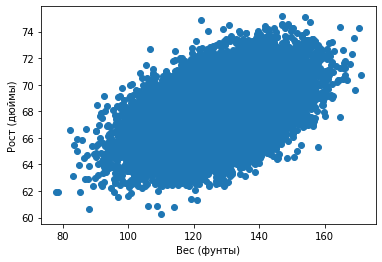

In [ ]:
plt.scatter(data_demo["Weight"], data_demo["Height"])
plt.xlabel("Вес (фунты)")
plt.ylabel("Рост (дюймы)");

In [ ]:
X, y = data_demo["Weight"].values, data_demo["Height"].values

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=17)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([X_valid.shape[0], 1]))

Обучите созданный вами `SGDRegressor` на выборке `(X_train_scaled, y_train)`. Параметры оставьте по умолчанию.

In [ ]:
""" ВАШ КОД ЗДЕСЬ """
sgdregressor = SGDRegressor(n_iter=2)
sgdregressor.fit(X_train_scaled, y_train)

0 : MSE = 4626.155 , w =  [0. 0.]
1 : MSE = 2.719 , w =  [68.038  0.911]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


SGDRegressor(eta=None, n_iter=None)

Изобразите на графике процесс обучения – как среднеквадратичная ошибка зависит от номера итерации стохастического градиентного спуска.

In [ ]:
sgdregressor.mse_

array([4.61685284e+03, 4.60833727e+03, 4.59876872e+03, ...,
       2.71841133e+00, 2.71838648e+00, 2.71865180e+00])

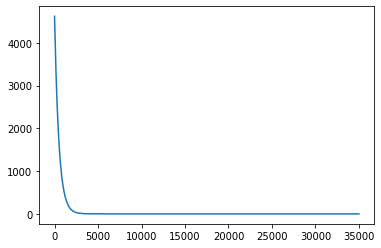

In [ ]:
""" ВАШ КОД ЗДЕСЬ """
plt.plot(sgdregressor.mse_);

Выведите наименьшее значение среднеквадратичной ошибки и лучший вектор весов модели.

In [ ]:
""" ВАШ КОД ЗДЕСЬ """
sgdregressor.mse_[np.argmin(sgdregressor.mse_)], sgdregressor.w_

(2.7151352148331966, array([67.98984926,  0.94449031]))

Постройте график того, как менялись значения весов модели ($w_0$ и $w_1$) по мере обучения.

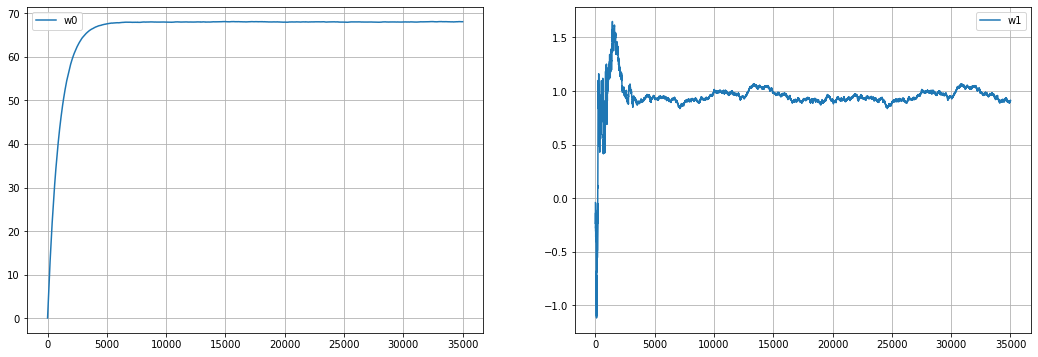

In [ ]:
""" ВАШ КОД ЗДЕСЬ """
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(sgdregressor.weights_[:, 0], label='w0')
plt.legend()
plt.grid()
plt.subplot(122)
plt.plot(sgdregressor.weights_[:, 1], label='w1')
plt.legend()
plt.grid();

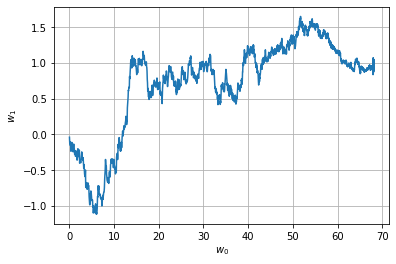

In [ ]:
""" ВАШ КОД ЗДЕСЬ """
plt.plot(sgdregressor.weights_[:, 0], sgdregressor.weights_[:, 1])
plt.xlabel('$w_0$'); plt.ylabel('$w_1$'); plt.grid();

Сделайте прогноз для отложенной выборки `(X_valid_scaled, y_valid)` и посмотрите на MSE.

In [ ]:
""" ВАШ КОД ЗДЕСЬ """
mean_squared_error(y_valid, sgdregressor.predict(X_valid_scaled))

2.670867559718745

Теперь следайте то же самое, но с `LinearRegression` из `sklearn.linear_model`. Посчитайте MSE для отложенной выборки.

In [ ]:
""" ВАШ КОД ЗДЕСЬ """
from sklearn.linear_model import LinearRegression
mean_squared_error(y_valid, LinearRegression().fit(X_train_scaled, y_train).predict(X_valid_scaled))

2.670830767667634

<font color='red'>Вопрос 1.</font> В каком знаке после разделителя отличаются MSE линейной регрессии и `SGDRegressor` для отложенной выборки?
 - 2
 - 3
 - 4
 - **+ 5**

## 2. Логистическая регрессия и SGD
Теперь давайте разберемся, как при таком же стохастическом подходе обучать логистическую регрессию.

Задача классификации, $X$ – обучающая выборка размеров $\ell \times (d+1)$ (первый столбец – вектор из единиц), $y$ – вектор ответов, $y_i \in \{-1, 1\}$.
В [4 статье](https://habrahabr.ru/company/ods/blog/323890/) серии мы подробно разбирали, как логистическая регрессия с $L_2$-регуляризацией сводится к задаче минимизации:
$$ C\sum_{i=1}^\ell \log{(1 + e^{-y_iw^Tx_i})} + \frac{1}{2}\sum_{j=1}^d w_j^2 \rightarrow min_w$$

<font color='red'>Вопрос 2.</font> По какой формуле будут пересчитываться веса логистической регрессии при обучении стохастическим градиентным спуском?
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) +  \delta_{j\neq0} w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) +  \delta_{j\neq0}w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j )$
 - **+** $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j)$
 
Здесь 
- $i \in {0,\ldots, \ell-1}, j \in {0,\ldots, d}$
- C – коэффициент регуляризации
- $x_{ij} $ – элемент матрицы X в строке $i$ и столбце $j$ (нумерация с 0), 
- $x_i$ – $i$-ая строка матрицы $X$ (нумерация с 0), 
- $w_j^{(t)}$ – значение $j$-ого элемента вектора весов $w$ на шаге $t$ стохастического градиентного спуска
- $\eta$ – небольшая константа, шаг градиентного спуска
- $\delta_{j\neq0}$ – символ Кронекера, то есть 1, когда $j\neq0$ и $0$ – в противном случае

Реализуйте класс `SGDClassifier`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$), `n_iter` – число проходов по выборке (по умолчанию 10) и C – коэффициент регуляризации
- также в конструкторе должны создаваться списки `loss_` и `weights_` для отслеживания значений логистических потерь и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit`, `predict` и `predict_proba`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`, рассматриваем только случай бинарной классификации, и значения в векторе `y` могут быть -1 и 1), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса по выведенной вами формуле, а также записывает получившиеся на данной итерации значения log_loss и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDClassifier`, т.е. `self`
- Метод `predict_proba` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает матрицу прогнозов модели (такую же, какую возвращают методы `predict_proba` моделей `sklearn`), используя созданный методом `fit` вектор весов `w_`
- Метод `predict` вызывает метод  `predict_proba` и возвращает вектор ответов: -1, если предсказанная вероятность класса 1 меньше 0.5 и 1 – в противном случае
- И еще **важный момент**: во избежание вычислительных проблем из-за слишком больших или малых значений под экспонентной (overflow & underflow) используйте написанную функцию `sigma`

In [ ]:
def sigma(z):
    z = z.flatten()
    z[z > 100] = 100
    z[z < -100] = -100
    return 1.0 / (1 + np.exp(-z))

$w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j)$

In [ ]:
# В ответах инициализируют веса единицами! Ответы не сходятся поэтому...
class SGDClassifier(BaseEstimator):
  """ ВАШ КОД ЗДЕСЬ """
  def __init__(self, C, eta=1e-3, n_iter=10):
    self.__eta = eta
    self.__n_iter = n_iter
    self.__C = C
    self.loss_ = []
    self.weights_ = []

  def fit(self, X, y, verbose=True):
    self.__l = X.shape[0]
    X = np.hstack((np.ones((self.__l, 1)), X))
    self.__w = np.ones(X.shape[1]) # self.__w = np.zeros(X.shape[1])
    self.__loss = log_loss(y, sigma(np.dot(X, self.__w)))
    
    for k in range(self.__n_iter):
      if verbose:
        print(k, ': loss = %.3f' % self.__loss, ', w = ', np.round(self.__w, 3))
      for i in range(self.__l):
        self.__w[0] += self.__eta * y[i] * sigma(-y[i]*np.dot(self.__w, X[i, :]))
        #self.__w += self.__eta * (self.__C * y[i] * X[i]*sigma(-y[i]*self.__w.T*X[i]) - self.__w)
        for j in range(1, X.shape[1]):
          self.__w[j] += self.__eta * (self.__C * y[i] * X[i, j]*sigma(-y[i]*np.dot(self.__w,X[i, :])) - self.__w[j])
        self.__pred = sigma(np.dot(X, self.__w))
        self.__loss = log_loss(y, self.__pred)
        self.loss_.append(np.copy(self.__loss))
        self.weights_.append(np.copy(self.__w))
    
    k += 1
    if verbose:
      print(k, ': loss = %.3f' % self.__loss, ', w = ', np.round(self.__w, 3))
    self.w_ = self.weights_[np.argmin(self.loss_)]
    print('best iter:', np.argmin(self.loss_))
    self.weights_ = np.array(self.weights_)
    self.loss_ = np.array(self.loss_)
    return self

  def predict(self, X):
    return np.where(self.predict_proba(X)[:, 1] < 0.5, -1, 1)

  def predict_proba(self, X):
    X = np.hstack((np.ones((X.shape[0],1)),X))
    self.__proba = sigma(np.dot(X, self.w_))
    return np.dstack((1-self.__proba, self.__proba))[0]

Проверим `SGDClassifier` на данных UCI по раку молочной железы.

In [ ]:
from sklearn.datasets import load_breast_cancer

In [ ]:
cancer = load_breast_cancer()
# поменяем метки в y с 0 на -1
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=17)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

Обучите на масштибированной выборке `SGDClassifier` с параметрами `C`=1, `eta`=$10^{-3}$ и `n_iter`=3.

In [ ]:
""" ВАШ КОД ЗДЕСЬ """
sgdclassifier = SGDClassifier(C=1, n_iter=3)
sgdclassifier.fit(X_train_scaled, y_train)

0 : loss = 0.693 , w =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
1 : loss = 0.394 , w =  [ 0.045 -0.073 -0.047 -0.074 -0.07  -0.033 -0.057 -0.071 -0.081 -0.03
  0.004 -0.05   0.004 -0.049 -0.046  0.012 -0.024 -0.018 -0.036  0.009
  0.    -0.08  -0.054 -0.08  -0.073 -0.048 -0.063 -0.072 -0.084 -0.049
 -0.038]
2 : loss = 0.336 , w =  [ 0.082 -0.097 -0.065 -0.098 -0.092 -0.041 -0.071 -0.09  -0.105 -0.037
  0.011 -0.066  0.006 -0.064 -0.061  0.017 -0.025 -0.018 -0.042  0.013
  0.008 -0.106 -0.075 -0.107 -0.098 -0.063 -0.081 -0.094 -0.11  -0.067
 -0.047]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


SGDClassifier(C=None, eta=None, n_iter=None)

Постройте график изменения log_loss.

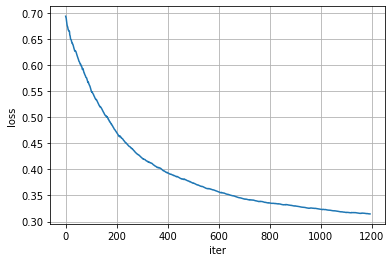

In [ ]:
""" ВАШ КОД ЗДЕСЬ """
plt.plot(sgdclassifier.loss_)
plt.xlabel('iter'); plt.ylabel('loss'); plt.grid();

Теперь обучите `SGDClassifier` с параметром `C`=1000, число проходов по выборке увеличьте до 10.

In [ ]:
""" ВАШ КОД ЗДЕСЬ """
sgdclassifier1000 = SGDClassifier(C=1000).fit(X_train_scaled, y_train)

0 : loss = 13.544 , w =  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.]
1 : loss = 0.057 , w =  [ 1.005 -1.757 -1.178 -0.96   0.034 -1.198  2.122 -1.951 -1.686  0.247
 -0.136 -1.439 -0.326 -0.702 -0.664  0.44   1.035 -0.226  0.377  0.213
  0.569 -0.657 -0.363 -0.495 -0.542 -1.653 -0.658 -1.265 -0.739 -0.84
 -0.354]
2 : loss = 0.053 , w =  [ 1.004 -1.347 -0.921 -0.577  0.023 -0.737  1.785 -1.819 -1.671  0.211
  0.203 -1.577 -0.19  -0.64  -0.847  0.329  1.317 -0.343  0.275  0.162
  0.651 -0.857 -0.506 -0.684 -0.787 -1.804 -0.616 -1.423 -0.855 -0.87
 -0.429]
3 : loss = 0.052 , w =  [ 1.003 -1.204 -0.852 -0.378 -0.    -0.576  1.5   -1.676 -1.642  0.173
  0.351 -1.652 -0.124 -0.558 -0.925  0.285  1.442 -0.402  0.22   0.123
  0.677 -0.944 -0.552 -0.768 -0.912 -1.862 -0.558 -1.478 -0.882 -0.845
 -0.468]
4 : loss = 0.052 , w =  [ 1.002 -1.149 -0.823 -0.265 -0.021 -0.515  1.307 -1.569 -1.614  0.153
  0.437 -1.698 -0.093 -0.488 -0.962  0.269  1.50

In [ ]:
sgdclassifier1000.weights_[0]

array([0.99999244, 0.99684755, 0.98861822, 0.99760782, 0.99778935,
       1.00031756, 1.00647461, 1.00509756, 1.00278461, 1.00567795,
       1.0068508 , 0.97794865, 0.98535067, 0.98159358, 0.99019774,
       0.99908337, 1.00416011, 1.00159088, 0.99050213, 1.00844606,
       1.00346027, 1.00053607, 0.99930965, 1.0010391 , 1.00085199,
       1.00887302, 1.00661674, 1.00604769, 1.00663971, 1.01160117,
       1.00787357])

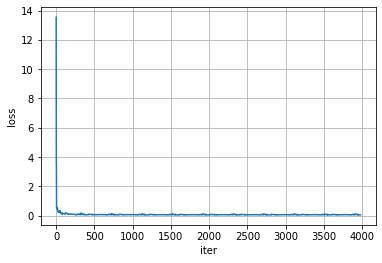

In [ ]:
""" ВАШ КОД ЗДЕСЬ """
plt.plot(sgdclassifier1000.loss_)
plt.xlabel('iter'); plt.ylabel('loss'); plt.grid();

In [ ]:
# 1я итерация:
log_loss(y_train, sigma(np.dot(np.hstack((np.ones([X_train_scaled.shape[0],1]), X_train_scaled)), sgdclassifier1000.weights_[0])))

13.548751655341023

Посмотрите на веса модели, при которых ошибка на обучении была минимальна.

<font color='red'>Вопрос 3.</font> Какой признак сильнее остальных влияет на вероятность того, что опухоль доброкачественна, согласно обученной модели `SGDClassifier`? (будьте внимательны – проверьте длину вектора весов, полученного после обучения, сравните с числом признаков в исходной задаче)
 - worst compactness
 - worst smoothness
 - worst concavity
 - concave points error
 - concavity error
 - compactness error
 - worst fractal dimension

In [ ]:
""" ВАШ КОД ЗДЕСЬ """
print(np.argmax(np.abs(sgdclassifier1000.w_)), ": %.3f" % 
      (np.sign(sgdclassifier1000.w_[np.argmax(np.abs(sgdclassifier1000.w_))]) *
                                            np.abs(sgdclassifier1000.w_).max()))

2 : -2.318


In [ ]:
cancer.feature_names[2-1]

'mean texture'

In [ ]:
pd.DataFrame({'coef':sgdclassifier1000.w_, 'feat':['w0']+list(cancer.feature_names)}).sort_values(by='coef')

,coef,feat
2,-2.317992,mean texture
1,-2.191250,mean radius
11,-2.128320,radius error
25,-1.878383,worst smoothness
8,-1.664048,mean concave points
27,-1.578306,worst concavity
7,-1.529498,mean concavity
24,-1.129153,worst area
21,-1.098365,worst radius
14,-1.040535,area error


Посчитайте log_loss и ROC AUC на отложенной выборке, проделайте все то же с `sklearn.linear_model.LogisticRegression` (параметры по умолчанию, только random_state=17) и сравните результаты.

In [ ]:
""" ВАШ КОД ЗДЕСЬ """
print('logloss:', log_loss(y_valid, sgdclassifier1000.predict_proba(X_valid_scaled)[:, 1]))
print('roc_auc:', roc_auc_score(y_valid, sgdclassifier1000.predict_proba(X_valid_scaled)[:, 1]))

logloss: 0.10456339792928346
roc_auc: 0.992101341281669


In [ ]:
sgdclassifier1000.predict_proba(X_valid_scaled)[0].sum()

1.0

## 3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

Теперь посмотрим на логистическую регрессию и ее же версию, но обучаемую стохастическим градиентным спуском, в задаче классификации отзывов IMDB. С этой задачей мы знакомы по 4 и 8 темам курса. Данные можно скачать [отсюда](https://drive.google.com/open?id=1xq4l5c0JrcxJdyBwJWvy0u9Ad_pvkJ1l).

Импортируем файлы, и обучим на имеющихся данных `CountVectorizer`

In [1]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

In [ ]:
# поменяйте путь к файлу
reviews_train = load_files("/imdb_reviews/train")
text_train, y_train = reviews_train.data, reviews_train.target

In [ ]:
reviews_test = load_files("/imdb_reviews/test")
text_test, y_test = reviews_test.data, reviews_test.target

Обучим на имеющихся данных `CountVectorizer`, считая биграммы, то есть перейдем к разреженному представлению данных, где каждому уникальному слову и паре подряд идущих слов в обучающей выборке соответсвует признак. Всего таких признаков получается более 1.5 млн.

In [ ]:
%%time
cv = CountVectorizer(ngram_range=(1, 2))
X_train = cv.fit_transform(text_train)
X_test = cv.transform(text_test)

CPU times: user 35.6 s, sys: 977 ms, total: 36.6 s
Wall time: 36 s


In [ ]:
X_train.shape, X_test.shape

((25000, 1513832), (25000, 1513832))

Обучите на выборке `(X_train, y_train)` логистическую регрессию с параметрами по умолчанию (только укажите `random_state`=17) и посчитайте ROC AUC на тестовой выборке. Замерьте время обучения модели. Данные можно не масштабировать, так как признаки – по сути, счетчики, и они уже все измеряются примерно в одном диапазоне.

In [5]:
from sklearn.linear_model import LogisticRegression

In [10]:
%%time
""" ВАШ КОД ЗДЕСЬ """
roc_auc_score(y_test, LogisticRegression(random_state=17).fit(X_train, y_train).predict(X_test))

CPU times: user 2min 41s, sys: 4.8 s, total: 3min 03s
Wall time: 42 s
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='auto', 
          n_jobs=None, penalty='l2', random_state=17, solver='lbfgs', 
          tol=0.0001, verbose=0, warm_start=False)
0.9582477248000001


Теперь перейдем к онлайн-алгоритму. Мы написали свой `SGDClassifier` и принцип его работы поняли, надо еще немного постараться, чтобы сделать его эффективным, например, сделать поддержку разреженных данных. Но мы теперь перейдем к `sklearn`-реализации SGD-алгоритма. Прочитайте документацию [SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), сделайте выводы, чем `SGDClassifier` из `Sklearn` более продвинут, чем наша реализация SGD-классификатора. 

<font color='red'>Вопрос 4.</font> Чем `sklearn`-реализация стохастического классификатора более продвинута, чем `SGDClassifier`, который мы реализовали? Отметьте все подходящие варианты.
 - Изменяемый шаг градиентного спуска
 - Реализован линейный SVM
 - Реализована ранняя остановка во избежание переобучения
 - Есть распараллеливание по процессорам
 - Можно обучать LASSO
 - Поддерживается онлайн-обучение деревьев решений
 - Поддерживается mini-batch подход (обновление весов по нескольким объектом сразу, а не по одному)


Проведите 100 итераций SGD-логрегрессии (опять `random_state`=17) на той же выборке. Опять замерьте время обучения модели и обратите внимание, насколько оно меньше, чем время обучения логистической регрессии.

In [14]:
%%time
""" ВАШ КОД ЗДЕСЬ """
roc_auc_score(y_test, SGDClassifier(random_state=17).fit(X_train, y_train).predict(X_test))

CPU times: user 7.92 s, sys: 68.3 ms, total: 7.55 s
Wall time: 7.25 s
SGDClassifier(alpha=0.0001, average=False, class_weight=None, 
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True, 
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None, 
       n_iter=100, n_jobs=1, penalty='l2', power_t=0.5, random_state=17, 
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.9573458688


<font color='red'>Вопрос 5.</font> В каком знаке после разделителя отличаются ROC AUC на тестовой выборке логистической регрессии и SGD-классификатора `Sklearn` с логистической функцией потерь?
 - 2
 - **+ 3**
 - 4
 - 5

In [ ]:
def to_vw_format(document, label=None):
    return str(label or '') + ' |text ' + ' '.join(re.findall('\w{3,}', document.lower())) + '\n'

to_vw_format(text, 1 if target == 'rec.autos' else -1)

In [ ]:
def convert_to_vw(raw_text, target):
  word_pattern = re.compile(r"[a-zA-Z0-9_]+")
  words = []
  for match in re.finditer(word_pattern, raw_text.lower()):
    words.append(match.group(0))                        

  if not words:
    return None
  return "{} |d {}".format(float(target), ' '.join(words))

def write_vw(X_data, Y_data, filename):
  with open(filename, 'w') as f:
    for x, y in zip(X_data, Y_data):
      vw_object = convert_to_vw(x, y)
      if not vw_object:
        continue
      f.write(vw_object + '\n')

#https://www.coursera.org/lecture/machine-learning-on-big-data/praktichieskoie-zaniatiie-vowpal-wabbit-FZXUA